device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


step 0 | loss 2.5434
step 1 | loss 1.9187
step 2 | loss 1.6549
step 3 | loss 1.4816
step 4 | loss 1.3323
step 5 | loss 1.2276
step 6 | loss 1.1192
step 7 | loss 1.0197
step 8 | loss 0.9270
step 9 | loss 0.8322


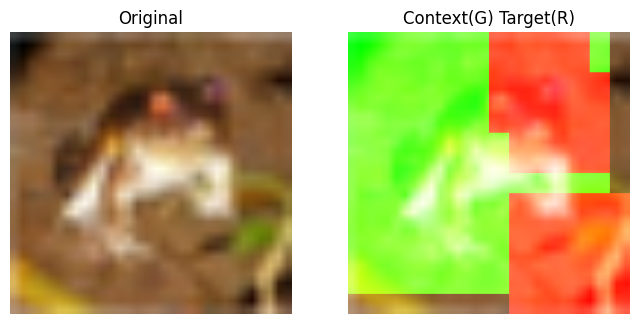

 Finished — this is a correct toy I-JEPA


In [5]:

# Toy I-JEPA (ViT-style) — COMPLETE & CLEAN


!pip -q install torchvision

import math, random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Device

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


# Data

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

-
# Mask utilities

GRID = 14
N_TOKENS = GRID * GRID

def sample_block_mask(grid=14, scale=(0.15,0.20)):
    area = grid * grid
    target_area = random.uniform(*scale) * area
    side = int(math.sqrt(target_area))
    side = max(1, min(grid, side))
    top = random.randint(0, grid-side)
    left = random.randint(0, grid-side)
    mask = torch.zeros(grid,grid,dtype=torch.bool)
    mask[top:top+side, left:left+side] = True
    return mask

def sample_context_mask(grid=14, scale=(0.85,1.0)):
    area = grid * grid
    ctx_area = random.uniform(*scale) * area
    side = int(math.sqrt(ctx_area))
    side = max(1, min(grid, side))
    top = random.randint(0, grid-side)
    left = random.randint(0, grid-side)
    mask = torch.zeros(grid,grid,dtype=torch.bool)
    mask[top:top+side, left:left+side] = True
    return mask

def remove_overlap(ctx, targets):
    for t in targets:
        ctx = ctx & (~t)
    return ctx

def mask_to_idx(mask):
    return torch.where(mask.flatten())[0]


# Model blocks

class PatchEmbed(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.proj = nn.Conv2d(3, dim, kernel_size=16, stride=16)

    def forward(self,x):
        x = self.proj(x)          # [B,D,14,14]
        x = x.flatten(2).transpose(1,2)  # [B,196,D]
        return x

class TinyViT(nn.Module):
    def __init__(self, dim=256, depth=4, heads=8):
        super().__init__()
        layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.enc = nn.TransformerEncoder(layer, depth)

    def forward(self,x):
        return self.enc(x)

@torch.no_grad()
def ema_update(teacher, student, m=0.996):
    for pt, ps in zip(teacher.parameters(), student.parameters()):
        pt.data.mul_(m).add_(ps.data, alpha=1-m)


# Toy I-JEPA

class ToyIJEPA(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.patch = PatchEmbed(dim)
        self.pos = nn.Parameter(torch.zeros(1, N_TOKENS, dim))
        self.student = TinyViT(dim)
        self.teacher = TinyViT(dim)
        self.predictor = TinyViT(dim, depth=2)
        self.mask_token = nn.Parameter(torch.zeros(1,1,dim))

        self.teacher.load_state_dict(self.student.state_dict())
        for p in self.teacher.parameters():
            p.requires_grad = False

    def forward(self, imgs):
        B = imgs.size(0)
        tokens = self.patch(imgs) + self.pos

        targets = [sample_block_mask() for _ in range(4)]
        ctx = remove_overlap(sample_context_mask(), targets)

        ctx_idx = mask_to_idx(ctx)
        tgt_idx = mask_to_idx(torch.stack(targets).any(dim=0))
        T = tgt_idx.numel()

        with torch.no_grad():
            target_repr = self.teacher(tokens)[:, tgt_idx]

        ctx_tokens = tokens[:, ctx_idx]
        ctx_out = self.student(ctx_tokens)

        tgt_pos = self.pos[:, tgt_idx].expand(B,T,-1)
        mask_slots = self.mask_token.expand(B,T,-1) + tgt_pos

        pred_in = torch.cat([ctx_out, mask_slots], dim=1)
        pred_out = self.predictor(pred_in)
        pred_targets = pred_out[:, -T:]

        loss = ((pred_targets - target_repr)**2).mean()
        return loss, ctx, targets


# Train (sanity)

model = ToyIJEPA().to(device)
opt = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4
)

model.train()
imgs,_ = next(iter(train_loader))
imgs = imgs.to(device)

for step in range(10):
    opt.zero_grad()
    loss,_,_ = model(imgs)
    loss.backward()
    opt.step()
    ema_update(model.teacher, model.student)
    print(f"step {step} | loss {loss.item():.4f}")


# Visualization

def visualize(img, ctx, targets):
    img = img.permute(1,2,0).numpy()
    h = img.shape[0] // GRID
    overlay = img.copy()

    for i in range(GRID):
        for j in range(GRID):
            if ctx[i,j]:
                overlay[i*h:(i+1)*h, j*h:(j+1)*h, 1] = 1

    for t in targets:
        for i in range(GRID):
            for j in range(GRID):
                if t[i,j]:
                    overlay[i*h:(i+1)*h, j*h:(j+1)*h, 0] = 1

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Context(G) Target(R)"); plt.axis("off")
    plt.show()

img,_ = train_ds[0]
with torch.no_grad():
    _, ctx, targets = model(img.unsqueeze(0).to(device))

visualize(img, ctx, targets)

print(" Finished — this is a correct toy I-JEPA")